In [52]:
import kipoi
import kipoi_interpret
import numpy as np
import tensorflow as tf
from kipoi_veff.utils.plot import seqlogo_heatmap
from concise.preprocessing.sequence import encodeDNA
from kipoiseq.dataloaders import SeqIntervalDl
from matplotlib import pyplot as plt

<h1>list all available methods/models


In [3]:
#kipoi.list_models()
kipoi_interpret.importance_scores.available_methods()

{'mutation': kipoi_interpret.importance_scores.ism.Mutation,
 'saliency': kipoi_interpret.importance_scores.gradient.Saliency,
 'grad*input': kipoi_interpret.importance_scores.gradient.GradientXInput,
 'grad': kipoi_interpret.importance_scores.gradient.Gradient,
 'deeplift': kipoi_interpret.importance_scores.referencebased.DeepLift,
 'intgrad': kipoi_interpret.importance_scores.referencebased.IntegratedGradients}

<h1>Kipoi interpret models

In [4]:
# Import Kipoi interpret models

# Gradient-based methods
from kipoi_interpret.importance_scores.gradient import Gradient, GradientXInput
# In-silico mutagenesis-based methods
from kipoi_interpret.importance_scores.ism import Mutation
# DeepLift
from kipoi_interpret.importance_scores.referencebased import DeepLift

In [26]:
# Custom saliency models

class Saliency(Gradient):
    def score(self, input_batch):
        return np.abs(super(Saliency, self).score(input_batch))

(1, 101, 4)


<h1>Select Model</h1>

In [143]:
# model = kipoi.get_model("DeepBind/Homo_sapiens/TF/D00765.001_ChIP-seq_GATA1")
model = kipoi.get_model("DeepBind/Homo_sapiens/TF/D00328.018_ChIP-seq_CTCF")
# model = kipoi.get_model("DeepBind/Homo_sapiens/RBP/D00096.001_RNAcompete_DAZAP1")
# model = kipoi.get_model("Basenji")
# model = kipoi.get_model("Basset")
# model = kipoi.get_model("pwm_HOCOMOCO/human/AHR")
# model = kipoi.get_model("FactorNet/MAX/onePeak_Unique35_DGF")

Using downloaded and verified file: /Users/brandon/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/TF/D00328.018_ChIP-seq_CTCF/arch/0d6747991a525b94a1ac9174459c2bf4
Using downloaded and verified file: /Users/brandon/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/TF/D00328.018_ChIP-seq_CTCF/weights/838eb7287139a2542f21984e692a9be2


<h1>Single Example</h1>

(1, 101, 4)
Score shape (101, 4)


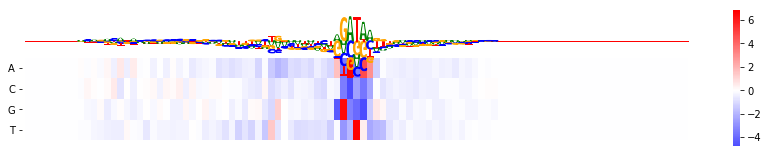

In [31]:
# Expected data shape for deepbind

# Encode sequence
seq = "ATGGGCCAGCACACAGACCAGCACGTTGCCCAGGAGCTGTGGGAGGAAGATAAGAGGTATGAACATGATTAGCAAAAGGGCCTAGCTTGGACTCAGAATAA"
seqa = encodeDNA([seq]) # one-hot-encode thesequence
print(seqa.shape)

# Calculate score
gradient = Gradient(model)
val = gradient.score(seqa)[0]
print('Score shape', val.shape)

# Score map
fig = plt.figure(figsize=(15,2.5))
seqlogo_heatmap(val, val.T, ax=plt.subplot())

<h1>Randomized Example</h1>

100%|██████████| 1/1 [00:00<00:00, 112.82it/s]


Selecting indices [3 0 4 1 5]


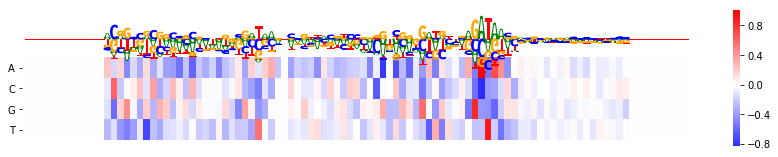

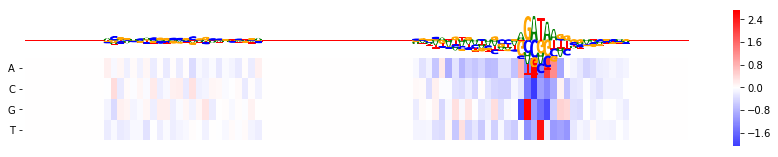

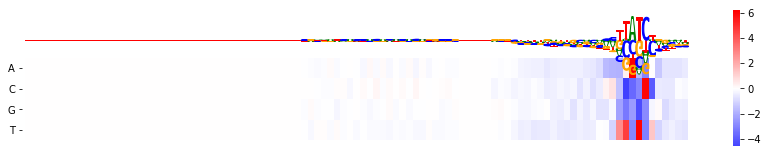

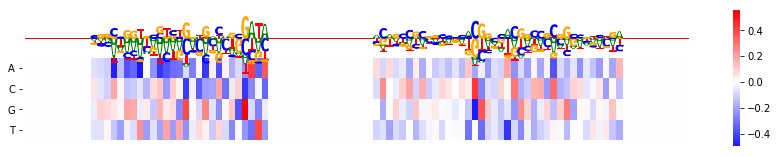

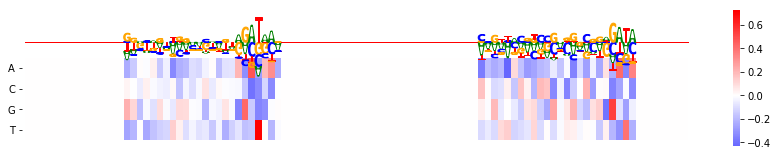

In [39]:
# get the example dataloader
dl_kwargs = model.default_dataloader.download_example('example')
dl = model.default_dataloader(**dl_kwargs)

# load all of the data
all = dl.load_all()  # load the whole dataset
data = all['inputs']
num_sequences_to_select = 5
indices = np.random.choice(data.shape[0], num_sequences_to_select, replace=False)  

# compute the gradients
gradient = Gradient(model)
print('Selecting indices', indices)
for x in indices:
    val = gradient.score(data[x:x+1,:,:])[0]
    fig = plt.figure(figsize=(15,2.5))
    seqlogo_heatmap(val, val.T, ax=plt.subplot())

<h1>Saliency Analysis</h1>

In [46]:
# Gather seq data
path = 'nbt3300-code/data/dream5/chipseq'

import glob
import pandas as pd
allFiles = glob.glob(path + '/*100_genomic*.seq')
# allFiles = glob.glob(path + '/TF_23_CHIP_100*.seq')

list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,header=None, sep='\t')
    list_.append(df)

frame = pd.concat(list_, axis = 0, ignore_index = True)
print('Read data frame', frame.shape)
frame_ones = frame.loc[frame[1] == 1]
print('Ones', frame_ones.shape)

# Encode the sequences
seqs = frame[0]
print('Sequences shape', seqs.shape)
data = encodeDNA(seqs) # one-hot-encode thesequence
print('Encoded data shape', data.shape)

Read data frame (4992, 2)
Ones (2496, 2)
Sequences shape (4992,)
Encoded data shape (4992, 101, 4)


<h2>Model Randomization

In [167]:
print(model.name)
model.get_layers_and_outputs(use_final_layer=True)

DeepBind/Homo_sapiens/TF/D00328.018_ChIP-seq_CTCF


([<keras.layers.merge.Maximum at 0x1258e3a58>],
 [<tf.Tensor 'maximum_571_3/Maximum:0' shape=(?,) dtype=float32>],
 [2])

In [168]:
km = model.model
print(km.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_819 (InputLayer)          (None, None, 4)      0                                            
__________________________________________________________________________________________________
lambda_2207 (Lambda)            (None, None, 4)      0           input_819[0][0]                  
__________________________________________________________________________________________________
lambda_2208 (Lambda)            (None, None, 4)      0           lambda_2207[0][0]                
__________________________________________________________________________________________________
conv1d_819 (Conv1D)             (None, None, 16)     2320        lambda_2207[0][0]                
                                                                 lambda_2208[0][0]                
__________

In [173]:
def score_with_method(method, data):
    scores = np.empty(data.shape)
    for x in range(len(data)):
        scores[x] = method.score(data[x:x+1,:,:])[0]
    return scores

from sklearn.metrics import mean_squared_error
def calculate_mse_scores(original_scores_3d, new_scores_3d):
    result = 0
    for i in range(len(scores)):
        mse = mean_squared_error(original_scores_3d[i], new_scores_3d[i])
        result += mse
    return result

def save_weights(keras_model, weights):
    for i in range(len(weights)):
        keras_model.layers[i].set_weights(weights[i])

def to_array(isval):
    """Temporary convert the output to a numpy array
    """
    def to_vec(x):
        if x is None:
            return 0
        else:
            if isinstance(x, list):
                return x[0]
            else:
                return x
    return np.array([[to_vec(y) for y in x] for x in isval])

def get_random_and_current_weights(km):
    sess = tf.InteractiveSession()
    tf.initializers.global_variables().run()

    new_weights = [layer.get_weights() for layer in km.layers]
    original_weights = new_weights.copy()
    for l in range(len(new_weights)):
        layer = new_weights[l]
        if len(layer) > 0:
            for i in range(len(layer)):
                var_shape = layer[i].shape
                new_weights[l][i] = np.random.random(var_shape)    
    return new_weights, original_weights

<h2>Mean Squared Error Analysis</h2>

In [184]:
method = Gradient(model)
new_weights, original_weights = get_random_and_current_weights(model.model)
original_scores = score_with_method(method, data)
save_weights(model.model, new_weights)
new_scores = score_with_method(method, data)
save_weights(model.model, original_weights)

mse = calculate_mse_scores(original_scores, new_scores)
print('Total MSE:', mse)
print('Among %s datapoints: %s' % (len(data), mse/len(data)))

Total MSE: 19055.980754071163
Among 4992 datapoints: 3.817303836953358


In [ ]:
method = GradientXInput(model)
new_weights, original_weights = get_random_and_current_weights(model.model)
original_scores = score_with_method(method, data)
save_weights(model.model, new_weights)
new_scores = score_with_method(method, data)
save_weights(model.model, original_weights)

mse = calculate_mse_scores(original_scores, new_scores)
print('Total MSE:', mse)
print('Among %s datapoints: %s' % (len(data), mse/len(data)))

Total MSE: 4230.020802093769
Among 4992 datapoints: 0.8473599363168608


In [ ]:
method = Saliency(model)
new_weights, original_weights = get_random_and_current_weights(model.model)
original_scores = score_with_method(method, data)
save_weights(model.model, new_weights)
new_scores = score_with_method(method, data)
save_weights(model.model, original_weights)

mse = calculate_mse_scores(original_scores, new_scores)
print('Total MSE:', mse)
print('Among %s datapoints: %s' % (len(data), mse/len(data)))